In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lifetimes
import seaborn as sns 
import math

In [2]:
df = pd.read_parquet("transactional_dataset_train.parquet")

In [3]:
df.head()

,account_id,event_time,amount
0,132285932,2021-08-14 21:18:04.956,19.99
1,131792942,2021-08-14 21:28:33.266,9.99
2,180084640,2021-08-14 19:10:59.833,0.99
3,132486244,2021-08-14 20:35:14.897,9.99
4,131970262,2021-08-14 19:30:59.234,0.99


In [4]:
df["amount"].describe()

count    161075.000000
mean          5.941833
std           9.208794
min           0.990000
25%           1.990000
50%           2.990000
75%           4.990000
max          99.990000
Name: amount, dtype: float64

# Dataset overview

In [5]:
maxdate = df["event_time"].dt.date.max()
mindate = df["event_time"].dt.date.min()
number_of_unique_customers = df["account_id"].nunique()
total_spend = df["amount"].sum()

print(f"Time range of all transactions is from {mindate} to {maxdate}")
print(f"Total number of unique ID: {number_of_unique_customers}")
print(f"Total spend is: {total_spend}")  

Time range of all transactions is from 2021-02-02 to 2021-08-20
Total number of unique ID: 69858
Total spend is: 957080.7100000001


# Historical approach

In [6]:
CLV_Historic = df.groupby("account_id").agg({"event_time": lambda x: (df["event_time"].max()-x.max()).days,
                                            "account_id": lambda x: len(x),
                                            "amount": lambda x: sum(x)})

In [7]:
CLV_Historic.columns = ["Age","Frequency","Total_amount"]
CLV_Historic.sort_values(by="Frequency",ascending=False)
CLV_Historic["type_of_buyer"] = np.where(CLV_Historic["Frequency"]==1,"One_time","more_than_one")
CLV_Historic["count"] = np.where(CLV_Historic["type_of_buyer"]=="One_time",1,0)


In [8]:
ln_Total=[]
for i in range(0,len(CLV_Historic["Total_amount"])):
    ln_Total.append(math.log(CLV_Historic["Total_amount"][i]))
    
CLV_Historic["Ln_Total_Amount"]=ln_Total

In [9]:
ln_Total_F=[]
for i in range(0,len(CLV_Historic["Frequency"])):
    ln_Total_F.append(math.log(CLV_Historic["Frequency"][i]))
    
CLV_Historic["Ln_Frequency"]=ln_Total_F

In [10]:
CLV_Historic.sort_values(by="Frequency",ascending = False).head()

,Age,Frequency,Total_amount,type_of_buyer,count,Ln_Total_Amount,Ln_Frequency
account_id,,,,,,,
98491143,174,104,2756.96,more_than_one,0,7.921884,4.644391
167529481,57,97,1214.03,more_than_one,0,7.101701,4.574711
113958422,84,89,2655.11,more_than_one,0,7.884241,4.488636
169616730,47,83,2854.17,more_than_one,0,7.956536,4.418841
123433842,41,81,735.19,more_than_one,0,6.600129,4.394449


In [11]:
CLV_Historic_one_time_buyers = CLV_Historic[CLV_Historic["count"]==1]
CLV_Historic_one_time_buyers.sort_values(by="Total_amount",ascending=False).head()

,Age,Frequency,Total_amount,type_of_buyer,count,Ln_Total_Amount,Ln_Frequency
account_id,,,,,,,
130423134,12,1,99.99,One_time,1,4.60507,0.0
99779802,160,1,99.99,One_time,1,4.60507,0.0
157045881,104,1,99.99,One_time,1,4.60507,0.0
151135420,128,1,99.99,One_time,1,4.60507,0.0
129463743,17,1,99.99,One_time,1,4.60507,0.0


In [12]:
CLV_Historic_only_more_than_one = CLV_Historic[CLV_Historic["count"]!=1]
CLV_Historic_only_more_than_one.sort_values(by="Total_amount",ascending=False).head()

,Age,Frequency,Total_amount,type_of_buyer,count,Ln_Total_Amount,Ln_Frequency
account_id,,,,,,,
169616730,47,83,2854.17,more_than_one,0,7.956536,4.418841
98491143,174,104,2756.96,more_than_one,0,7.921884,4.644391
113958422,84,89,2655.11,more_than_one,0,7.884241,4.488636
125162993,34,80,1984.20,more_than_one,0,7.592971,4.382027
101436153,144,56,1891.44,more_than_one,0,7.545094,4.025352


In [13]:
print(CLV_Historic_one_time_buyers["Total_amount"].describe(percentiles = [.25,.5,.99]))
print("repetitive")
print(CLV_Historic_only_more_than_one["Total_amount"].describe(percentiles = [.25,.5,.95]))
print(CLV_Historic["Total_amount"].describe(percentiles = [.25,.5,.99]))
print(CLV_Historic["Total_amount"].describe())

count    39865.000000
mean         3.247722
std          4.699702
min          0.990000
25%          0.990000
50%          2.990000
99%         19.990000
max         99.990000
Name: Total_amount, dtype: float64
repetitive
count    29993.000000
mean        27.593447
std         64.767596
min          1.980000
25%          5.980000
50%         12.940000
95%         91.954000
max       2854.170000
Name: Total_amount, dtype: float64
count    69858.000000
mean        13.700374
std         44.258498
min          0.990000
25%          1.990000
50%          3.980000
99%        151.928600
max       2854.170000
Name: Total_amount, dtype: float64
count    69858.000000
mean        13.700374
std         44.258498
min          0.990000
25%          1.990000
50%          3.980000
75%          9.990000
max       2854.170000
Name: Total_amount, dtype: float64


<AxesSubplot:xlabel='Ln_Total_Amount', ylabel='Count'>

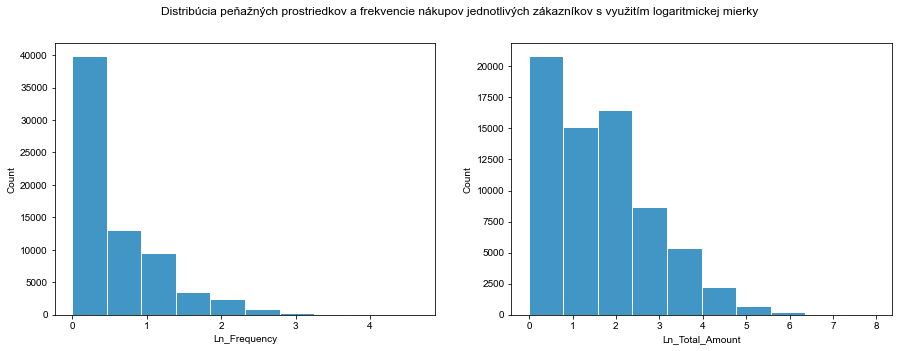

In [14]:
# grafy s vyuzitim logaritmickej skaly pomocou prirodzeneho logaritmu
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False,sharex=False)
fig.suptitle('Distribúcia peňažných prostriedkov a frekvencie nákupov jednotlivých zákazníkov s využitím logaritmickej mierky')
sns.set_theme(style="whitegrid",palette="colorblind")
sns.histplot(x=CLV_Historic["Ln_Frequency"],ax=axes[0],bins=10) # all buyers
sns.histplot(x=CLV_Historic["Ln_Total_Amount"],ax=axes[1],bins=10)

In [15]:
Average_amount = round(np.mean(CLV_Historic.Total_amount),2)
print(f"Average_amount: {Average_amount}")

Frequency = round(np.mean(CLV_Historic.Frequency),2)
print(f"Average Frequency: {Frequency}")

Retention_rate = CLV_Historic[CLV_Historic["Frequency"]>1].shape[0]/CLV_Historic.shape[0]
churn = round(1-Retention_rate,2)
print(f"Retention rate: {round(Retention_rate*100,2)}%")
print(f"Churn rate: {round(churn*100,2)}%")

Average_amount: 13.7
Average Frequency: 2.31
Retention rate: 42.93%
Churn rate: 57.0%


In [16]:
Profit_margin = 0.05

CLV = round((Average_amount*Frequency/churn)*Profit_margin,2)
print(f"customer lifetime value: {CLV}")

customer lifetime value: 2.78


# Cohort model with months 

In [17]:
customer = df.groupby("account_id").agg({"event_time": lambda x: x.min().month,
                                         "account_id": lambda x: len(x),
                                         "amount": lambda x: np.sum(x)})
                                        
customer.columns = ["Start_month", "Frequency", "Total_amount"]

customer

,Start_month,Frequency,Total_amount
account_id,,,
100000423,3,1,9.99
100001374,3,1,2.99
100001463,3,1,0.99
100001654,3,3,6.99
100003092,3,1,0.99
...,...,...,...
99995053,3,2,22.98
99995304,3,2,12.98
99996154,3,1,2.99


In [18]:
CLV_monthly = []

for i in range(2,9):
    customer_m = customer[customer["Start_month"]==i]

    Average_sales = np.mean(customer_m["Total_amount"])
    
    Purchase_frequency = np.mean(customer_m["Frequency"])
                                            
    Retention_rate = customer_m[customer_m["Frequency"]>1].shape[0]/customer_m.shape[0]
    churn_rate = 1-Retention_rate
    
    CLV=round((Average_sales*Purchase_frequency/churn_rate)*Profit_margin,2)
                                 
    CLV_monthly.append(CLV)

In [19]:
CLV_monthly

[2.95, 2.61, 2.93, 2.58, 2.47, 2.9, 2.91]

In [20]:
months=["Február","Marec","Apríl","Máj","Jún","Júl","August"]

In [21]:
print(pd.DataFrame(zip(months,CLV_monthly),columns = ["Mesiac","CLV"]))

    Mesiac   CLV
0  Február  2.95
1    Marec  2.61
2    Apríl  2.93
3      Máj  2.58
4      Jún  2.47
5      Júl  2.90
6   August  2.91


<AxesSubplot:xlabel='[Február, Marec, Apríl, Máj, Jún, Júl, August]'>

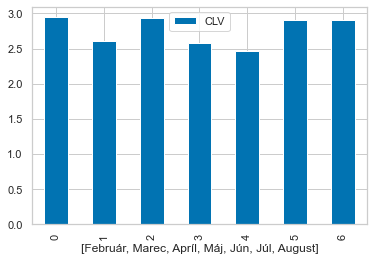

In [22]:
histogram = pd.DataFrame(zip(months,CLV_monthly),columns = ["Mesiac","CLV"])
histogram.plot(kind="bar",xlabel=histogram["Mesiac"])